https://www.gdal.org/gdal_retile.html



## Import

In [47]:
import pandas as pd
import geopandas # http://geopandas.org/reference.html
import matplotlib.pyplot as plt

import glob
import numpy as np

import os
import shutil     # Kopiering av filer
from osgeo import ogr, gdal    # GDAL

# Python kode som delar opp bildet.
import gdal_retile

In [43]:
# Check that unpacked files are there. Unpack them?
!ls ../Raw_data

20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.dat
20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.dat.aux.xml
20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.hdr
20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.zip
20180705-biri_02_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.dat
20180705-biri_02_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.hdr
20180705-biri_02_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.zip


In [44]:
# Global variables:
imagestripes_names = glob.glob('../Raw_data/*.dat') # Lists every imagestripe
imagestripes_out_dir = '../Merged_image_stripes/'



name_imagefiles= glob.glob('../Merged_image_stripes/*.tif') # Lists every imagefile
#ame_shapefile = "shapefile/utsnit.shp"
name_csv = 'tile_envelope_coordinates.csv'
in_directory = '../Sorted_tiles'
out_directory = '../Sorted_tiles/mis_tiles'

# Size of output tile
tile_with = '50'
tile_heigth = '50'

## Merge bands

In [45]:
imagestripes_names

['../Raw_data/20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.dat',
 '../Raw_data/20180705-biri_02_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.dat']

In [46]:
# Run merge function for each set of VNIR and SWNIR stripes
for i, k in enumerate(imagestripes_names[::2]):
    print(f'Prossesing stripe {i+1} of {len(name_imagefiles)}')
    print(f'Merging {name_imagestripes[1]} and {name_imagestripes[0]})

    
    # The highes resolution image as fist input. In this case VNIR before Swnir.
    cmd = 'gdal_merge.py -o '+ imagestripes_out_dir +'stripe_merged_'+ str(2+i) +'.tif -separate -v -ot Float32 -of GTiff '+ name_imagestripes[1] + name_imagestripes[0]
    
    os.system(cmd)


gdal_merge.py -o ../Merged_image_stripes/stripe_merged_2.tif -separate -v -ot Float32 -of GTiff ../Raw_data/20180705-biri_02_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.hdr../Raw_data/20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.dat.aux.xml
0


## Make tiles

In [21]:
# Run retilefunction for each image
for i, image_name in enumerate(name_imagefiles):
    print(f'Prossesing image {i+1} of {len(name_imagefiles)}')
    
    cmd = 'gdal_retile.py -ps ' + tile_with +' '+ tile_heigth + ' -overlap 0 -levels 1 -r near -ot Float32 -csv '+ str(i) + name_csv + ' -csvDelim "," -targetDir '+'\''+in_directory+'\''+ ' ' +'\''+image_name+'\''
    #print(cmd)
    os.system(cmd)

Prossesing image 1 of 1


## Find categories
Label 99 means that the tile contains no MIS-label.

In [5]:
MIS_code_key = pd.read_excel(io='../Prosjekt_Honne_data_Landbruksdirektoratet/Koder Mis-nin i shape pilot 2.0.xlsx', sheet_name='LM.kode')
MIS_code_key

,Kode,Navn
0,1,Stående død ved
1,2,Liggende død ved
2,3,Rikbarkstrær
3,4,Trær med hengelav
4,5,Eldre lauvsuksesjoner
5,6,Gamle trær
6,7,Hule lauvtrær
7,8,Brannflater
8,9,Rik bakkevegetasjon
9,10,Bergvegger


In [6]:
# Read mis-polygons
mis_geometry_mjosen = geopandas.read_file('../Prosjekt_Honne_data_Landbruksdirektoratet/Leveranse_MiS_201017_Mjosen/MiS_NiN_Biri_Mjosen_2017.shp')

mis_geometry_mjosen.head()

,OBJECTID,AREAL,REG_DATO_F,KGRAD,VERDI,NATURTYPE,KGRAD_BEGR,SKOGBESKRI,FORVALTNIN,FKODE,...,UT_EKSP,KI_VANNP,LIVSM1,LIVSM2,area,sum_lauv,sum_gamle,sum_LDV,sum_SDV,geometry
0,0,8,2017-09-01,0,None,0,None,Ensjiktet produksjonsskog av gran og noe bjørk...,None,1,...,b,A2,2,1,8159,0,0,19,16,"POLYGON ((585266.8620801514 6754440.302978287,..."
1,0,2,2017-09-01,0,None,0,None,Gamle furutrr I blanding med gran og noe lauv.,None,1,...,d,A2,6,0,2251,0,7,0,0,"POLYGON ((585548.5608584847 6754543.789799314,..."
2,0,3,2017-09-12,0,None,0,None,Bekkeklöft med noe liggende død ved og hengestry.,None,1,...,a,A2,12,2,3235,0,0,15,0,"POLYGON ((586009.7207604215 6754258.584550213,..."
3,0,3,2017-09-12,0,None,0,None,Liggende og noe stående død ved.,None,1,...,a,A2,2,0,2871,0,0,10,0,"POLYGON ((586245.598938267 6754403.08832045, 5..."
4,0,9,2017-09-13,0,None,0,None,Også noe stående død ved.,None,0,...,b,A2,2,0,9474,0,0,14,0,"POLYGON ((587132.3176386385 6754551.368164727,..."


<Figure size 432x288 with 0 Axes>

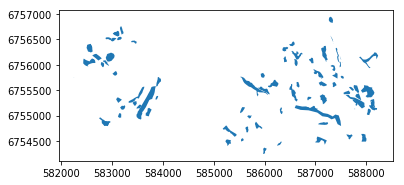

In [7]:
# Plot mis-polygons
plt.figure()
mis_geometry_mjosen.plot()
plt.show()

## Sort tiles

In [8]:
# Merge all csv files to one big
all_files = glob.glob(os.path.join(in_directory, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, names = ["Tile_name", "X_ul", "X_lr", "Y_ul", "Y_lr"]) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

In [13]:
concatenated_df.count()

Tile_name    1848
X_ul         1848
X_lr         1848
Y_ul         1848
Y_lr         1848
dtype: int64

In [14]:
concatenated_df.head()

,Tile_name,X_ul,X_lr,Y_ul,Y_lr
0,20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq...,582400.55,582435.55,6755306.65,6755341.65
1,20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq...,582435.55,582470.55,6755306.65,6755341.65
2,20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq...,582470.55,582505.55,6755306.65,6755341.65
3,20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq...,582505.55,582540.55,6755306.65,6755341.65
4,20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq...,582540.55,582575.55,6755306.65,6755341.65


In [26]:
# Create a geometry of every tile (bounding box)
# https://gis.stackexchange.com/questions/285336/convert-polygon-bounding-box-to-geodataframe
b = [geopandas.base.box(l, b, r, t) for l, b, r, t in zip(concatenated_df.X_ul, concatenated_df.Y_lr, concatenated_df.X_lr, concatenated_df.Y_ul)]

gdf = geopandas.GeoDataFrame(concatenated_df, geometry=b)

# Create dataframe to save labels
labeled_tiles = pd.DataFrame(gdf['Tile_name'])
labeled_tiles.index.name = 'ID'

# Create label collum, label 99 means no "no MIS label"
labeled_tiles["LIVSM1"] = int(99)
labeled_tiles["LIVSM2"] = int(99)

In [113]:
labeled_tiles.head()

NameError: name 'labeled_tiles' is not defined

In [28]:
# Modifisert
# Bruk informasjonen i mis_geometry.LIVSM_XXX for å tilegne klasse i sorteringa. Lagre dette i csv-fil eller inn i 
# concatenated_df. Då kan ein lese navn på flisa og i same slengen også leggje til miskoden inn i generatoren. Altså
# både x (imageread(filnamn)) og y (klassekoden).
# Check if a tile is inside a mis-polygon. Sorts tiles. 
for mis_geom_num, mis_geom_row in mis_geometry_mjosen.iterrows():
    print(f'Checking polygon {mis_geom_num + 1} of {len(mis_geometry_mjosen)}')

    # Check if tile geometries is inside a mis-polygon
    for index, row in gdf.iterrows():    
        # If tile is inside, sort it into folder
        if mis_geom_row['geometry'].contains(row['geometry']):
            #shutil.move(in_directory + '/' + row['Tile_name'], out_directory + '/' + row['Tile_name']) 
            labeled_tiles.loc[labeled_tiles.index[index], 'LIVSM1'] = (int(mis_geom_row['LIVSM1']))
            labeled_tiles.loc[labeled_tiles.index[index], 'LIVSM2'] = (int(mis_geom_row['LIVSM2']))

            #print(f'Label {gdf["mis_label"][index]} given tile {row["Tile_name"]}')
            print('Label LIVSM1 {0} LIVSM2 {1} given tile {2}'.format(labeled_tiles["LIVSM1"][index], labeled_tiles["LIVSM2"][index], row["Tile_name"]))

Checking polygon 1 of 83
Checking polygon 2 of 83
Checking polygon 3 of 83
Checking polygon 4 of 83
Checking polygon 5 of 83
Checking polygon 6 of 83
Checking polygon 7 of 83
Label LIVSM1 12 LIVSM2 0 given tile 20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_006_123.tif
Label LIVSM1 12 LIVSM2 0 given tile 20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_006_124.tif
Label LIVSM1 12 LIVSM2 0 given tile 20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_006_125.tif
Label LIVSM1 12 LIVSM2 0 given tile 20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_006_126.tif
Label LIVSM1 12 LIVSM2 0 given tile 20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_006_127.tif
Label LIVSM1 12 LIVSM2 0 given tile 20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_007_130.tif
Label LIVSM1 12 LIVSM2 0 given tile 20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_007_131.tif
Label LIVSM1 12 LIVSM2 0 given tile 20180705-biri_13_SWIR_384me_SN3126_raw_r

MultiLabelBinarizer is used to make a multilabel binary label. This labelvector is used by the model.

In [112]:
MultiLabelBinarizer is used to make a multilabel binary label. This labelvector is used by the model.
from sklearn.preprocessing import MultiLabelBinarizer

mergedlabels = [list(pair) for pair in zip(labelfile['LIVSM1'].values, labelfile['LIVSM2'].values)]


mlb = MultiLabelBinarizer(classes=[1,2,3,4,5,6,7,8,9,10,11,12,99])
binarized_labels = mlb.fit_transform(mergedlabels)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [188]:
# Convert binarized_labels to dataframe
bin_labels_dict = {'index': list(range(len(binarized_labels))), 
        'mult_bin_labels': binarized_labels.tolist()}
binarized_labels_dataframe = pd.DataFrame(bin_labels_dict, columns = ['index', 'mult_bin_labels'])

# view the dataset
binarized_labels_dataframe.head()

,index,mult_bin_labels
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [187]:
labeled_tiles = pd.concat([labeled_tiles, binarized_labels_dataframe['mult_bin_labels']], axis=1)
labeled_tiles.tail()

,index,mult_bin_labels,mult_bin_labels
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [29]:
# Save csv to file
labeled_tiles.to_csv('../Sorted_tiles/labeled_tiles.csv')

labeled_tiles.head()

,Tile_name,LIVSM1,LIVSM2
ID,,,
0,20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq...,0,0
1,20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq...,0,0
2,20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq...,0,0
3,20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq...,0,0
4,20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq...,0,0


## Read images

In [1]:
import imageio
im = imageio.imread('../Sorted_tiles/mis_tiles/20180705-biri_13_SWIR_384me_SN3126_raw_rad_bsq_float32_geo_01_22.tif')




/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functiona

In [2]:
im.shape

(256, 256, 288)

In [27]:
# Check if a tile is inside a mis-polygon. Sorts tiles. 
for polygon_num, polygon in enumerate(mis_geometry.geometry):
    print(f'Checking polygon {polygon_num + 1} of {len(mis_geometry.geometry)}')
    
    # Check if tile geometries is inside a mis-polygon
    for index, row in gdf.iterrows():
        print(row)
        # If tile is inside, sort it into folder
        if polygon.contains(row['geometry']):
            #shutil.move(in_directory + '/' + row['Tile_name'], out_directory + '/' + row['Tile_name']) 
            print(row['Tile_name'])

NameError: name 'mis_geometry_mjosen' is not defined

In [13]:
from PIL import ImageEnhance
from PIL import Image
import numpy as np

im = Image.open('../Sorted_tiles/1.jpg')
im2 = imageio.imread('../Sorted_tiles/1.jpg')


In [16]:
print(np.array(im).shape)
print(im2.shape)
print(im-im2)

(183, 275, 3)
(183, 275, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
